In [69]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")

Since we now have the fixed frequency land-mask and sea-mask variables in our holdings (`sftlf` and `sftof`), we can look into the nature of these files.

First, we check how many of the land-mask and sea-mask files there are per model and in what scenarios they occur. If the land-mask and sea-mask files occur in multiple scenarios, check to see if they are identical.

There is a possibility that the land and ocean fraction changes in the future projections, so we need to see if that is the case.

In [70]:
cmip6_dir = Path("/beegfs/CMIP6/arctic-cmip6/CMIP6")

all_fps = list(cmip6_dir.glob("**/*.nc"))
all_models = list(set([fp.parts[7] for fp in all_fps]))

In [71]:
model_fx_var_dict = {}

for model in all_models:
    # set up the dictionary for the model
    model_fx_var_dict[model] = {"sftlf": {}, "sftof": {}}

    # list files from the all_fps list that have the model name in them
    landmask_fps = [fp for fp in all_fps if model in fp.parts]

    # list all scenarios available for the model
    scenarios = list(set([fp.parts[8] for fp in landmask_fps]))

    # for each available scenario, list any landmask files that use that scenario
    for scenario in scenarios:
        model_fx_var_dict[model]["sftlf"][scenario] = []
        model_fx_var_dict[model]["sftof"][scenario] = []
        for fp in landmask_fps:
            if "sftlf" in fp.parts and scenario in fp.parts:
                model_fx_var_dict[model]["sftlf"][scenario].append(fp)
            if "sftof" in fp.parts and scenario in fp.parts:
                model_fx_var_dict[model]["sftof"][scenario].append(fp)

In [72]:
# check each model in the model_landmask_dict, and print messages indicating how many scenarios have landmask files
# if >1 scenario has landmask files, open the files and compare them to see if they are the same; print a message with the result


def print_fx_info(model_fx_var_dict, var):
    for model in model_fx_var_dict:
        scenarios = model_fx_var_dict[model][var].keys()
        scenario_count = len(scenarios)
        landmask_count = 0
        for scenario in scenarios:
            if len(model_fx_var_dict[model][var][scenario]) != 0:
                landmask_count += 1
        if landmask_count == 0:
            print(f"{model}: {var} files found for 0 of {scenario_count} scenarios")
        else:
            print(
                f"{model}: {var} files found for {landmask_count} / {scenario_count} scenarios"
            )
        if landmask_count > 1:
            fps = []
            for scenario in scenarios:
                for fp in model_fx_var_dict[model][var][scenario]:
                    fps.append(fp)
            # open all files in fps and compare them
            data = []
            for fp in fps:
                data.append(xr.open_dataset(fp))
            same = True
            for i in range(1, len(data)):
                if not data[i].equals(data[0]):
                    same = False
            if same:
                print(f"{model}: {var} files are the same")
            else:
                print(f"{model}: {var} files are different")
        print("\n")

In [73]:
print_fx_info(model_fx_var_dict, "sftlf")

CESM2: sftlf files found for 5 / 5 scenarios
CESM2: sftlf files are the same


E3SM-1-1: sftlf files found for 0 of 2 scenarios


TaiESM1: sftlf files found for 5 / 5 scenarios
TaiESM1: sftlf files are the same


MPI-ESM1-2-LR: sftlf files found for 0 of 5 scenarios


NorESM2-MM: sftlf files found for 5 / 5 scenarios
NorESM2-MM: sftlf files are the same


KACE-1-0-G: sftlf files found for 0 of 5 scenarios


E3SM-2-0: sftlf files found for 0 of 2 scenarios


CNRM-CM6-1-HR: sftlf files found for 1 / 5 scenarios


CESM2-WACCM: sftlf files found for 0 of 5 scenarios


HadGEM3-GC31-LL: sftlf files found for 0 of 4 scenarios


GFDL-ESM4: sftlf files found for 1 / 5 scenarios


EC-Earth3-Veg: sftlf files found for 5 / 5 scenarios
EC-Earth3-Veg: sftlf files are the same


MIROC6: sftlf files found for 5 / 5 scenarios
MIROC6: sftlf files are the same


HadGEM3-GC31-MM: sftlf files found for 0 of 3 scenarios


MPI-ESM1-2-HR: sftlf files found for 5 / 5 scenarios
MPI-ESM1-2-HR: sftlf files are th

In [74]:
print_fx_info(model_fx_var_dict, "sftof")

CESM2: sftof files found for 5 / 5 scenarios
CESM2: sftof files are the same


E3SM-1-1: sftof files found for 0 of 2 scenarios


TaiESM1: sftof files found for 0 of 5 scenarios


MPI-ESM1-2-LR: sftof files found for 0 of 5 scenarios


NorESM2-MM: sftof files found for 5 / 5 scenarios


NorESM2-MM: sftof files are the same


KACE-1-0-G: sftof files found for 0 of 5 scenarios


E3SM-2-0: sftof files found for 0 of 2 scenarios


CNRM-CM6-1-HR: sftof files found for 0 of 5 scenarios


CESM2-WACCM: sftof files found for 0 of 5 scenarios


HadGEM3-GC31-LL: sftof files found for 0 of 4 scenarios


GFDL-ESM4: sftof files found for 0 of 5 scenarios


EC-Earth3-Veg: sftof files found for 5 / 5 scenarios
EC-Earth3-Veg: sftof files are the same


MIROC6: sftof files found for 5 / 5 scenarios
MIROC6: sftof files are the same


HadGEM3-GC31-MM: sftof files found for 0 of 3 scenarios


MPI-ESM1-2-HR: sftof files found for 5 / 5 scenarios
MPI-ESM1-2-HR: sftof files are the same


MRI-ESM2-0: sftof files found for 5 / 5 scenarios
MRI-ESM2-0: sftof files are the same




OK, great. For the models that have multiple files for land-mask or sea-mask variables, we know that the files are all equal and we can use any one of these files in the regridding.

For models that do not have land-mask or sea-mask variables, we will have to just use the default regridder.

To test, let's regrid the `mrro` land-only variable and `siconc` sea-only variables for demonstration. First, make a dictionary with the first encountered `mrro` and `sftlf` files and the first encountered `siconc` and `sftof` files for each model.

In [75]:
regrid_demo_dict = {}
for model in model_fx_var_dict:
    regrid_demo_dict[model] = {
        "mrro": None,
        "sftlf": None,
        "siconc": None,
        "sftof": None,
    }
    # replace the sftlf and sftof files with the first one found in the model_fx_var_dict
    for scenario in model_fx_var_dict[model]["sftlf"]:
        if len(model_fx_var_dict[model]["sftlf"][scenario]) != 0:
            regrid_demo_dict[model]["sftlf"] = str(
                model_fx_var_dict[model]["sftlf"][scenario][0]
            )
            break
    for scenario in model_fx_var_dict[model]["sftof"]:
        if len(model_fx_var_dict[model]["sftof"][scenario]) != 0:
            regrid_demo_dict[model]["sftof"] = str(
                model_fx_var_dict[model]["sftof"][scenario][0]
            )
            break
    # find the first mrro file and first siconc file for the model in the all_fps list
    for fp in all_fps:
        if model in fp.parts and "mrro" in fp.parts:
            regrid_demo_dict[model]["mrro"] = str(fp)
            break
    for fp in all_fps:
        if model in fp.parts and "siconc" in fp.parts:
            regrid_demo_dict[model]["siconc"] = str(fp)
            break

In [76]:
regrid_demo_dict

{'CESM2': {'mrro': '/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370/r11i1p1f1/day/mrro/gn/v20200528/mrro_day_CESM2_ssp370_r11i1p1f1_gn_20150101-20641231.nc',
  'sftlf': '/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r11i1p1f1/fx/sftlf/gn/v20200528/sftlf_fx_CESM2_ssp585_r11i1p1f1_gn.nc',
  'siconc': '/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370/r11i1p1f1/SImon/siconc/gn/v20200528/siconc_SImon_CESM2_ssp370_r11i1p1f1_gn_201501-206412.nc',
  'sftof': '/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r11i1p1f1/Ofx/sftof/gn/v20200528/sftof_Ofx_CESM2_ssp585_r11i1p1f1_gn.nc'},
 'E3SM-1-1': {'mrro': None, 'sftlf': None, 'siconc': None, 'sftof': None},
 'TaiESM1': {'mrro': '/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/ssp585/r1i1p1f1/Lmon/mrro/gn/v20200901/mrro_Lmon_TaiESM1_ssp585_r1i1p1f1_gn_201502-210012.nc',
  'sftlf': '/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/ssp585/r1i1p1f1/fx/sftlf/gn/v20200

In [85]:
# function to load dataset and apply longitude correction; returns dataset for first time slice
def load_ds(fp, time=True):
    # open dataset and apply longitude correction
    ds = xr.open_dataset(fp)
    lon_enc = ds["lon"].encoding
    lon_attrs = ds["lon"].attrs
    # subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
    ds.coords["lon"] = (ds.coords["lon"] + 180) % 360 - 180
    ds["lon"].encoding = lon_enc
    ds["lon"].attrs = lon_attrs
    # sort
    ds = ds.sortby(ds.lon, ascending=True)
    if time == True:
        # get first time slice
        ds = ds.isel(time=[0])
    else:
        pass
    return ds


# function to plot target, target mask, source, source mask, and regridded datasets side by side
def regrid_plots(
    target_ds, src_ds, regrid_ds, threshold, var_id, mask_var_id, lat_slice, lon_slice
):
    fig, ax = plt.subplots(1, 4, figsize=(25, 4))
    vmin, vmax = (
        src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).min(),
        src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).max(),
    )

    target_ds["mask"].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[0])

    src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(
        ax=ax[1], vmin=vmin, vmax=vmax
    )
    try:
        src_ds["mask"].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[2])
    except:
        pass

    regrid_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(
        ax=ax[3], vmin=vmin, vmax=vmax
    )

    ax[0].set_title(f"target {mask_var_id} mask > {threshold}%")
    ax[1].set_title(f"{var_id} source data")
    ax[2].set_title(f"source {mask_var_id} mask > {threshold}%")
    ax[3].set_title(f"{var_id} regridded data")

    for a in range(len(ax)):
        ax[a].set_xlabel("")
        ax[a].set_ylabel("")

    plt.show()


# function to mask, regrid with model-specific mask, and plot
# # used only where the model offers a land or sea mask
def regrid_landseamask_and_plot(
    target_ds,
    target_landsea_mask,
    src_ds,
    src_landsea_mask,
    threshold,
    var_id,
    mask_var_id,
    lat_slice,
    lon_slice,
):
    # regrid both target and source model's land/sea mask to the model's source data (just in case there are discrepancies)
    target_regridder = xe.Regridder(
        target_landsea_mask, target_ds, method="bilinear", unmapped_to_nan=True
    )
    target_landsea_mask_regrid = target_regridder(target_landsea_mask, keep_attrs=True)

    src_regridder = xe.Regridder(
        src_landsea_mask, src_ds, method="bilinear", unmapped_to_nan=True
    )
    src_landsea_mask_regrid = src_regridder(src_landsea_mask, keep_attrs=True)

    # use land/sea area percentage threshold to create the mask variable in both target and source datasets
    src_ds["mask"] = xr.where((src_landsea_mask_regrid[mask_var_id] > threshold), 1, 0)
    target_ds["mask"] = xr.where(
        (target_landsea_mask_regrid[mask_var_id] > threshold), 1, 0
    )

    # regrid source to target, using extrapolation to fill inland NaNs;
    # regridder will recognize mask variables and act on the accordingly
    regridder = xe.Regridder(
        src_ds,
        target_ds,
        method="bilinear",
        extrap_method="nearest_s2d",
        unmapped_to_nan=True,
    )
    regrid_ds = regridder(src_ds, keep_attrs=True)

    # plot results
    regrid_plots(
        target_ds,
        src_ds,
        regrid_ds,
        threshold,
        var_id,
        mask_var_id,
        lat_slice,
        lon_slice,
    )


# function to mask, regrid with source land mask, and plot
# used only where the model does not offer a land or sea mask
def regrid_nolandseamask_and_plot(
    target_ds,
    target_landsea_mask,
    src_ds,
    threshold,
    var_id,
    mask_var_id,
    lat_slice,
    lon_slice,
):
    # regrid target model's land/sea mask to the model's source data (just in case there are discrepancies)
    target_regridder = xe.Regridder(
        target_landsea_mask, target_ds, method="bilinear", unmapped_to_nan=True
    )
    target_landsea_mask_regrid = target_regridder(target_landsea_mask, keep_attrs=True)

    # use land/sea area percentage threshold to create the mask variable in target dataset
    target_ds["mask"] = xr.where(
        (target_landsea_mask_regrid[mask_var_id] > threshold), 1, 0
    )

    # regrid source to target, using extrapolation to fill inland NaNs;
    # regridder will recognize mask variables and act accordingly
    regridder = xe.Regridder(
        src_ds,
        target_ds,
        method="bilinear",
        extrap_method="nearest_s2d",
        # unmapped_to_nan=True,
    )
    regrid_ds = regridder(src_ds, keep_attrs=True)

    # plot results
    regrid_plots(
        target_ds,
        src_ds,
        regrid_ds,
        threshold,
        var_id,
        mask_var_id,
        lat_slice,
        lon_slice,
    )


# function to plot input data and land/sea masks
def plot_data_and_landsea_masks(
    target_ds,
    target_landsea_mask,
    src_ds,
    src_landsea_mask,
    threshold,
    var_id,
    mask_var_id,
    lat_slice,
    lon_slice,
):

    fig, ax = plt.subplots(1, 6, figsize=(25, 4))
    vmin, vmax = (
        target_ds[var_id].sel(lat=lat_slice, lon=lon_slice).min(),
        target_ds[var_id].sel(lat=lat_slice, lon=lon_slice).max(),
    )

    target_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(
        ax=ax[0], vmin=vmin, vmax=vmax
    )

    target_landsea_mask[mask_var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[1])

    xr.where(target_landsea_mask[mask_var_id] > threshold, 1, 0).sel(
        lat=lat_slice, lon=lon_slice
    ).plot(ax=ax[2])

    try:
        src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(
            ax=ax[3], vmin=vmin, vmax=vmax
        )
    except:
        pass

    try:
        src_landsea_mask[mask_var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[4])
        xr.where(src_landsea_mask[mask_var_id] > threshold, 1, 0).sel(
            lat=lat_slice, lon=lon_slice
        ).plot(ax=ax[5])
    except:
        pass

    ax[0].set_title(f"{var_id} target data")
    ax[1].set_title(f"target {mask_var_id} mask")
    ax[2].set_title(f"target {mask_var_id} mask > {threshold}%")
    ax[3].set_title(f"{var_id} source data")
    ax[4].set_title(f"source {mask_var_id} mask")
    ax[5].set_title(f"source {mask_var_id} mask > {threshold}%")

    for a in range(len(ax)):
        ax[a].set_xlabel("")
        ax[a].set_ylabel("")

    plt.show()

In [86]:
# define coastal area used in plotting
lat_slice = slice(45, 74)
lon_slice = slice(-170, -130)

CESM2:


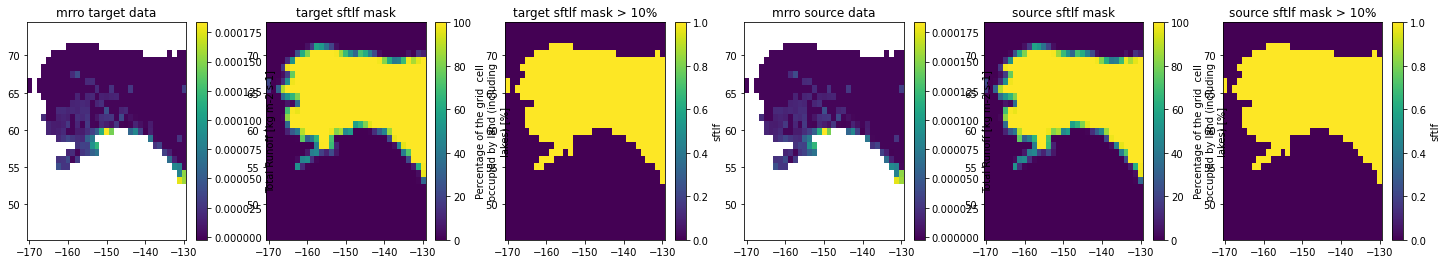



E3SM-1-1:
E3SM-1-1: no mrro files found
E3SM-1-1: no sftlf files found


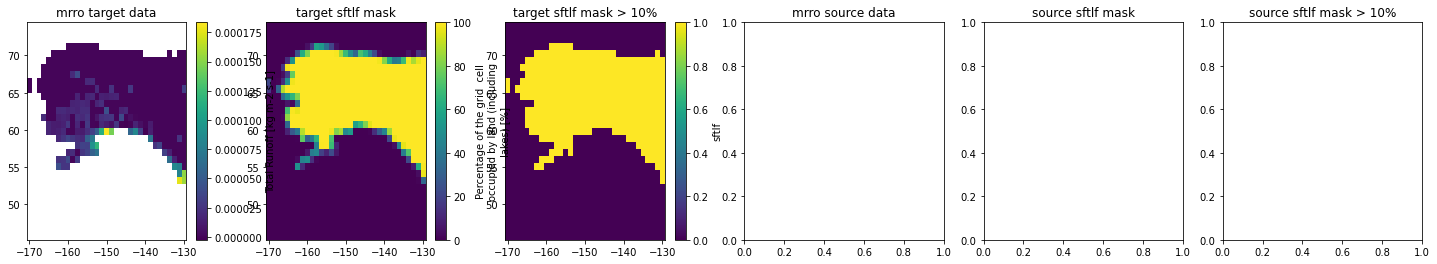



TaiESM1:


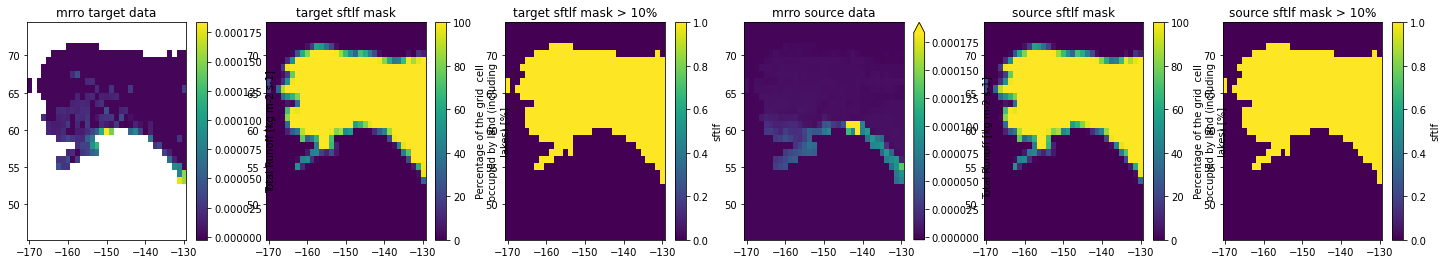



MPI-ESM1-2-LR:
MPI-ESM1-2-LR: no sftlf files found


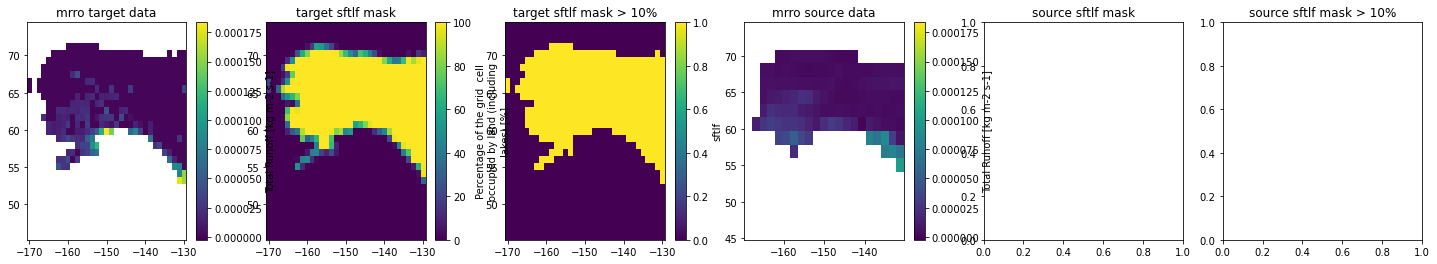



NorESM2-MM:


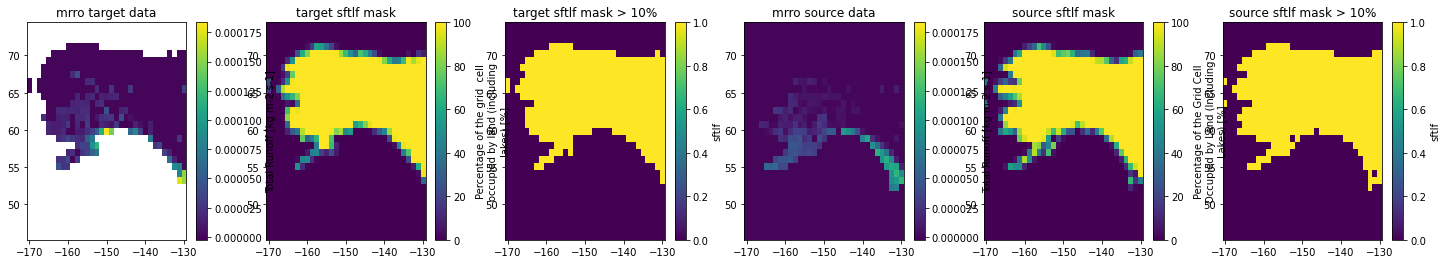



KACE-1-0-G:
KACE-1-0-G: no sftlf files found


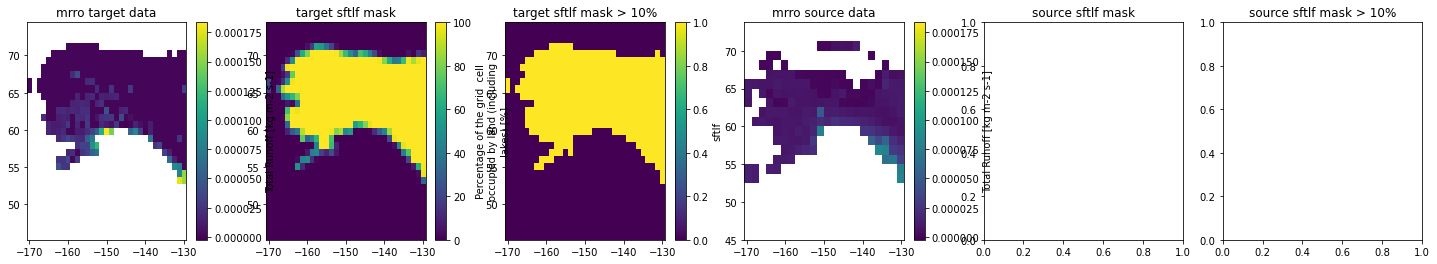



E3SM-2-0:
E3SM-2-0: no mrro files found
E3SM-2-0: no sftlf files found


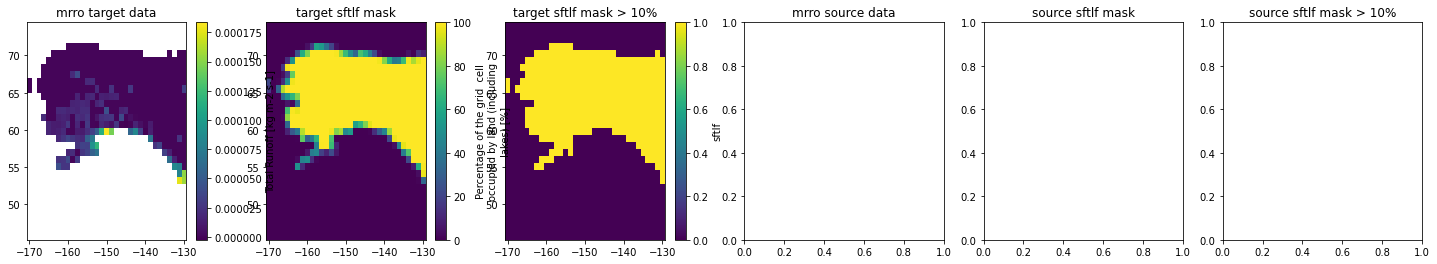



CNRM-CM6-1-HR:


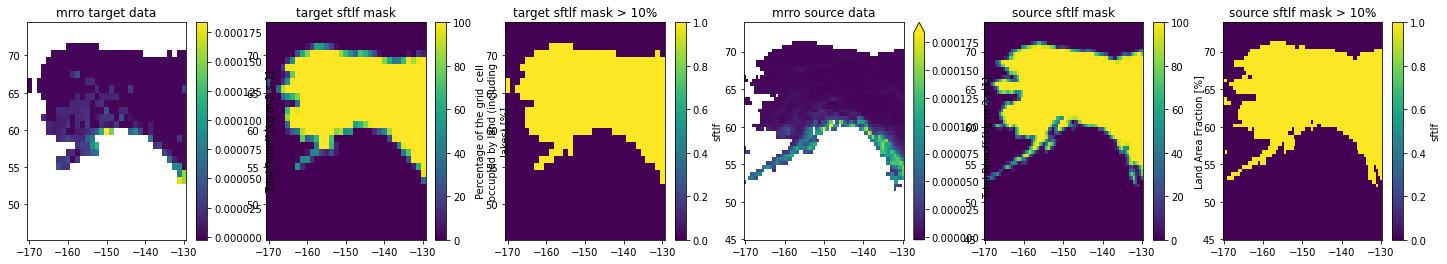



CESM2-WACCM:
CESM2-WACCM: no sftlf files found


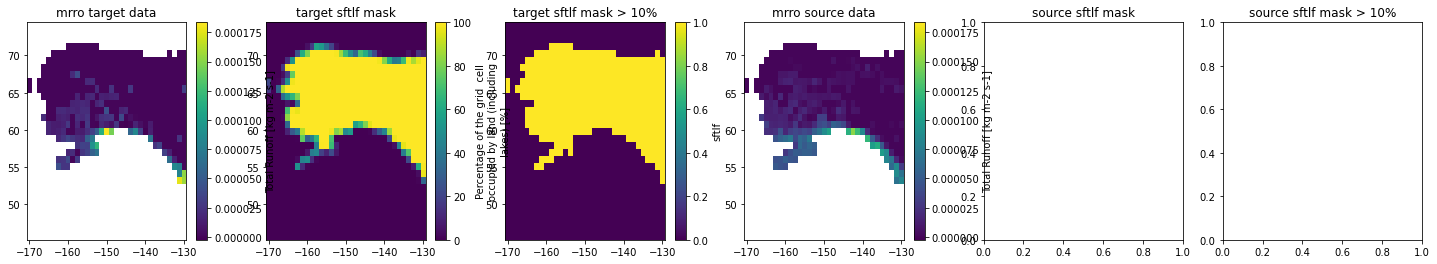



HadGEM3-GC31-LL:
HadGEM3-GC31-LL: no sftlf files found


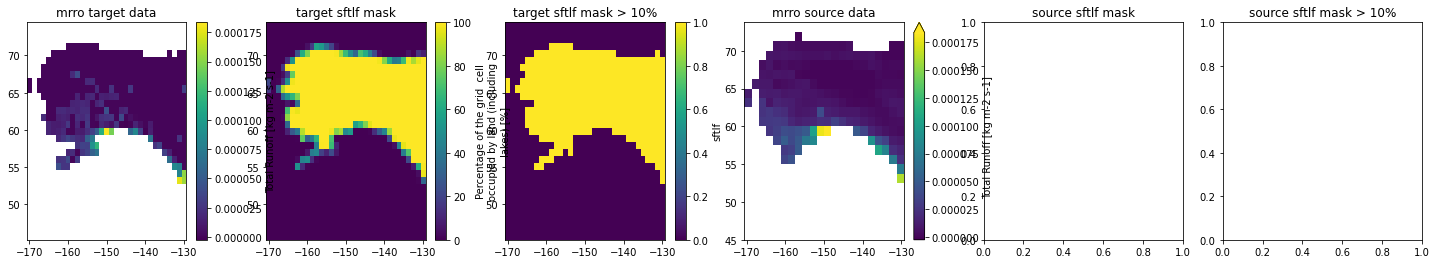



GFDL-ESM4:


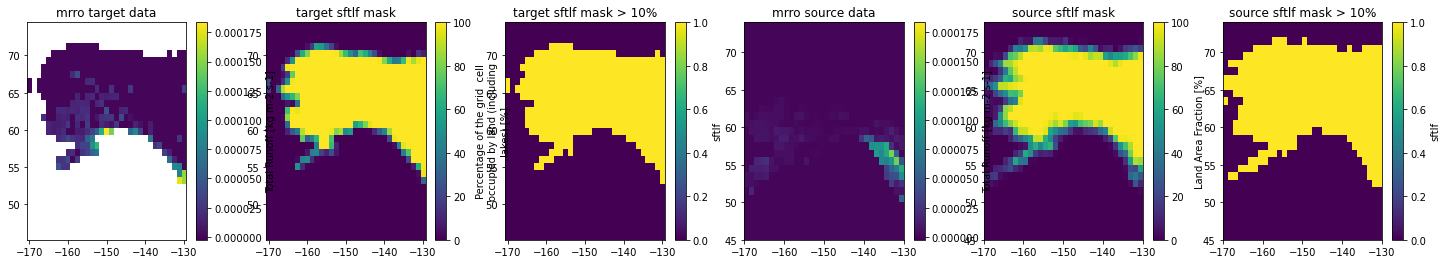



EC-Earth3-Veg:


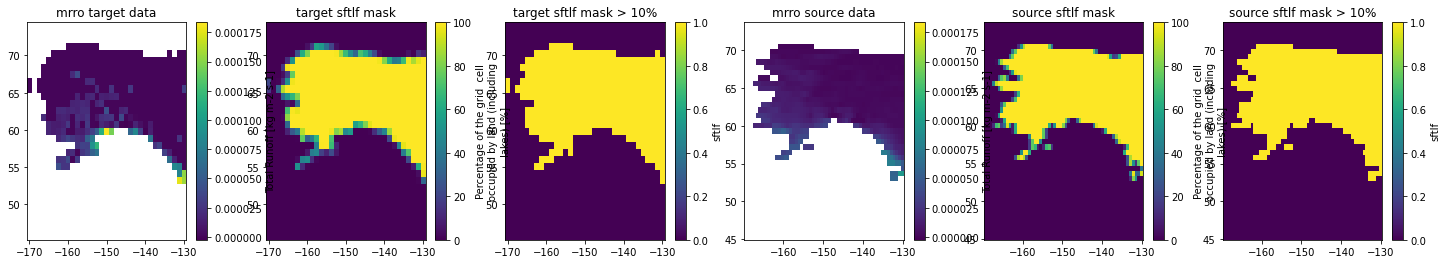



MIROC6:


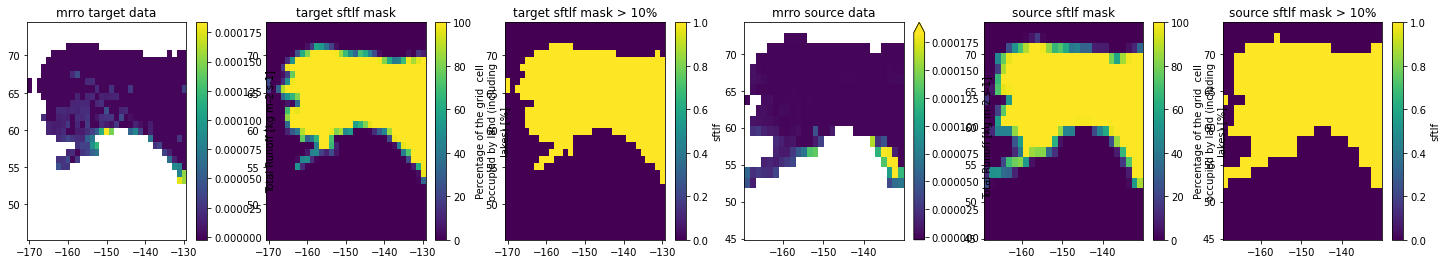



HadGEM3-GC31-MM:
HadGEM3-GC31-MM: no sftlf files found


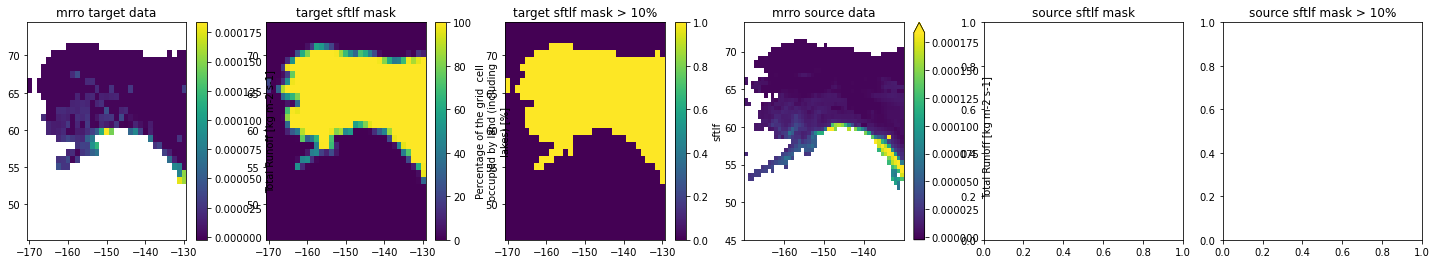



MPI-ESM1-2-HR:


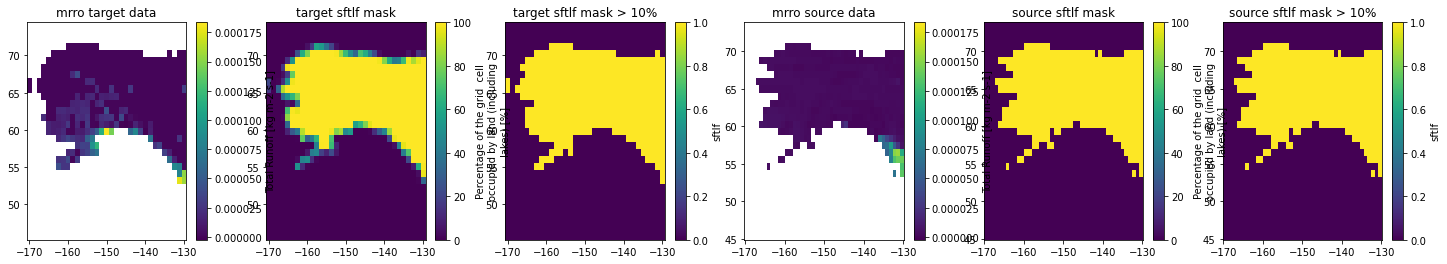



MRI-ESM2-0:


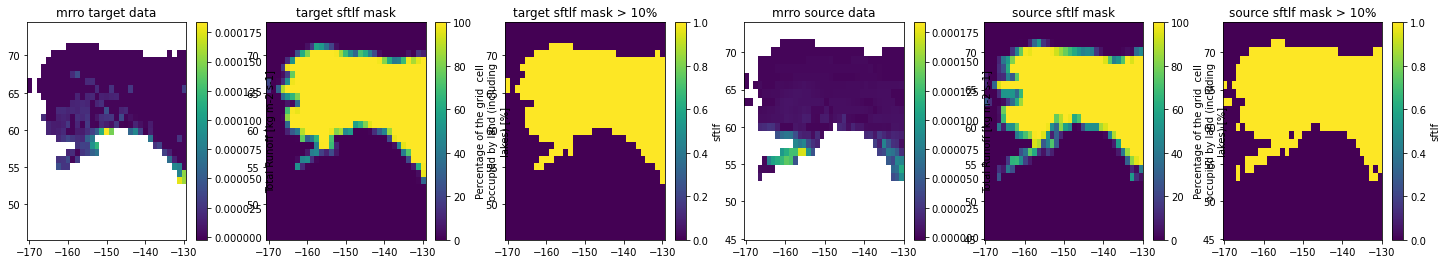

In [87]:
# for each model, plot source dataset and land/sea mask with threshold land %
threshold = 10
var, mask_var = "mrro", "sftlf"

# define CESM2 target grid dataset and land mask
target_ds = load_ds(regrid_demo_dict["CESM2"][var])
target_land_mask = load_ds(regrid_demo_dict["CESM2"][mask_var], time=False)

for model in regrid_demo_dict.keys():
    print(f"{model}:")
    # message if var or mask_var files are not found
    if regrid_demo_dict[model][var] is None:
        print(f"{model}: no {var} files found")
    if regrid_demo_dict[model][mask_var] is None:
        print(f"{model}: no {mask_var} files found")

    try:
        src_ds = load_ds(regrid_demo_dict[model][var])
    except:
        src_ds = None
    try:
        src_land_mask = load_ds(regrid_demo_dict[model][mask_var], time=False)
    except:
        src_land_mask = None

    plot_data_and_landsea_masks(
        target_ds,
        target_land_mask,
        src_ds,
        src_land_mask,
        threshold,
        var,
        mask_var,
        lat_slice,
        lon_slice,
    )
    print("\n")

CESM2: mrro and sftlf files found...regridding with model-specific land/sea mask
CESM2:


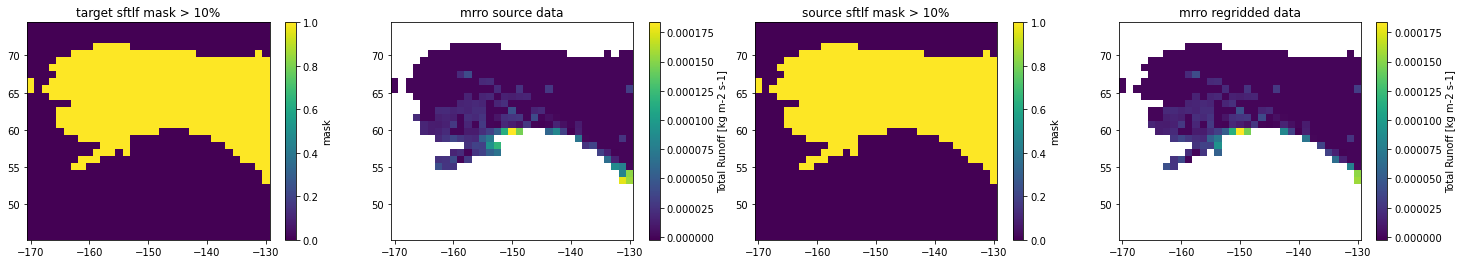

E3SM-1-1: no mrro files found to regrid

TaiESM1: mrro and sftlf files found...regridding with model-specific land/sea mask
TaiESM1:


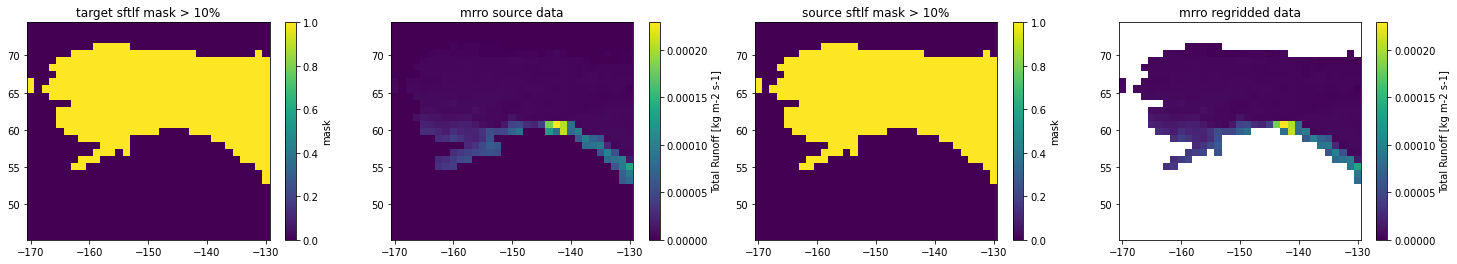

MPI-ESM1-2-LR: mrro files found, but no sftlf files found...regridding without model-specific land/sea mask
MPI-ESM1-2-LR:


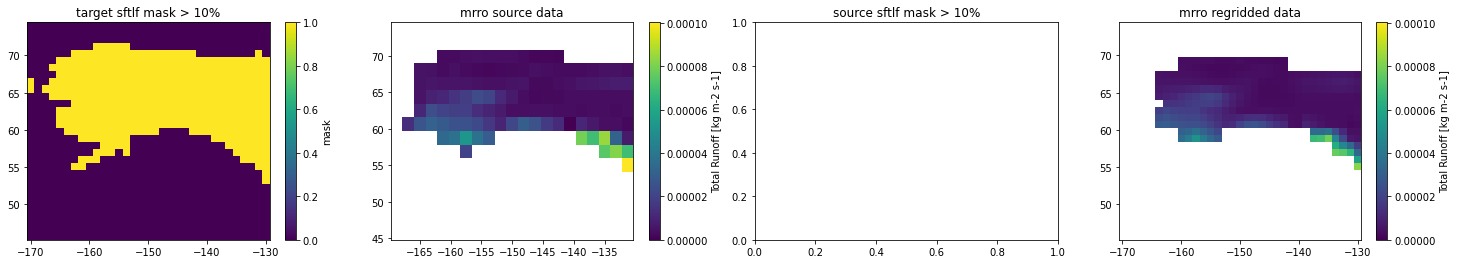

NorESM2-MM: mrro and sftlf files found...regridding with model-specific land/sea mask
NorESM2-MM:


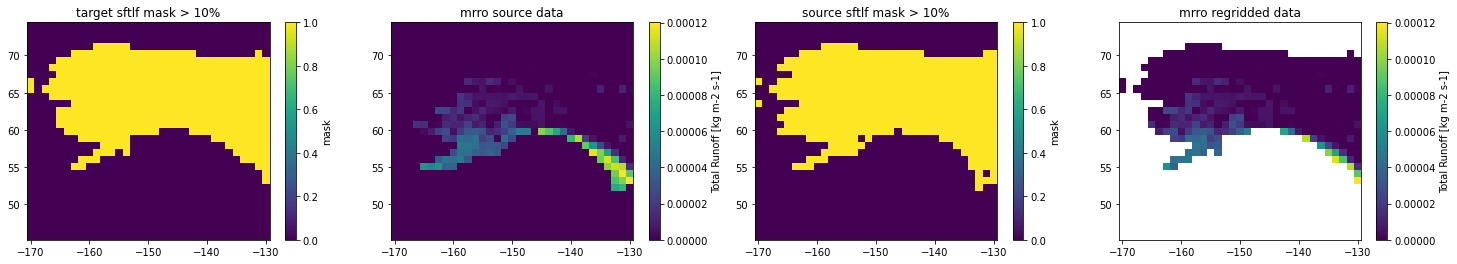

KACE-1-0-G: mrro files found, but no sftlf files found...regridding without model-specific land/sea mask
KACE-1-0-G:


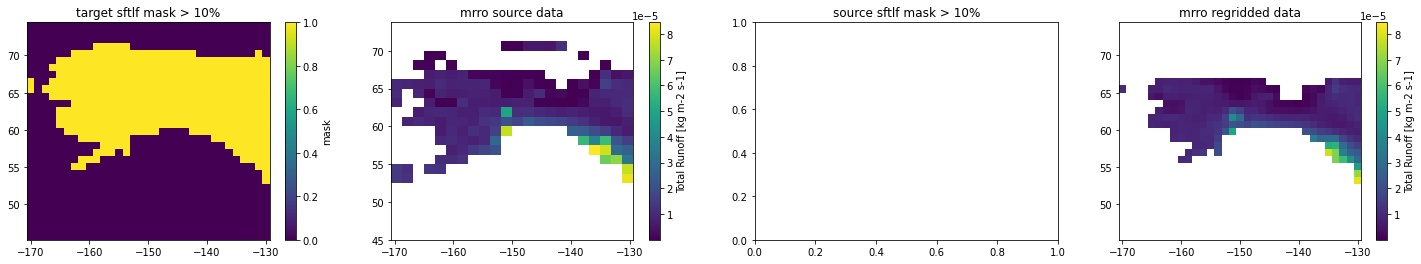

E3SM-2-0: no mrro files found to regrid

CNRM-CM6-1-HR: mrro and sftlf files found...regridding with model-specific land/sea mask
CNRM-CM6-1-HR:


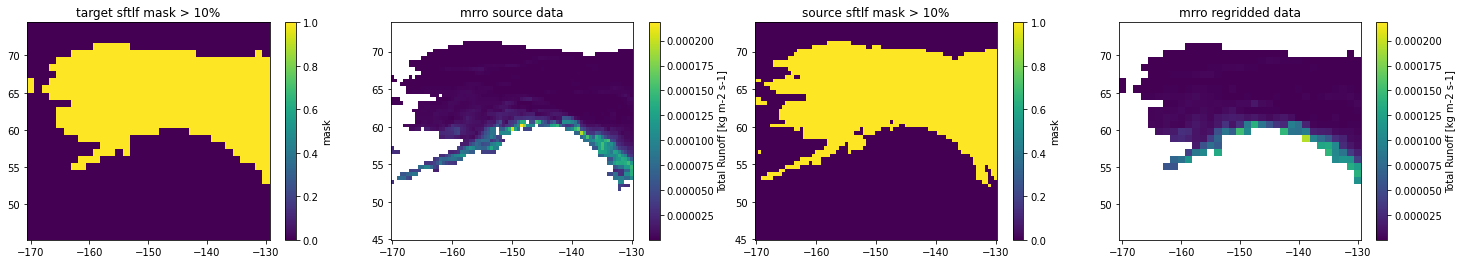

CESM2-WACCM: mrro files found, but no sftlf files found...regridding without model-specific land/sea mask
CESM2-WACCM:


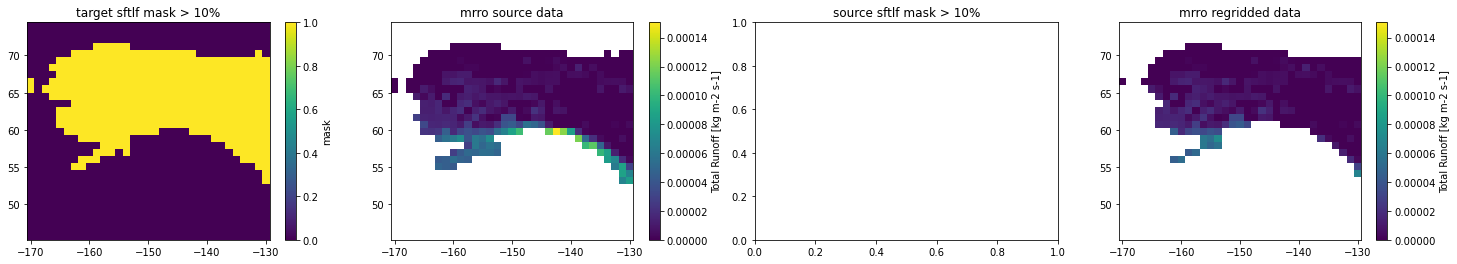

HadGEM3-GC31-LL: mrro files found, but no sftlf files found...regridding without model-specific land/sea mask
HadGEM3-GC31-LL:


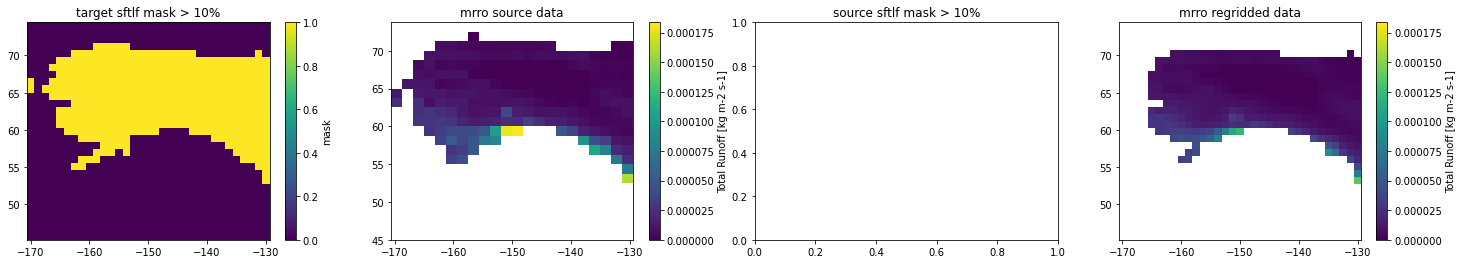

GFDL-ESM4: mrro and sftlf files found...regridding with model-specific land/sea mask
GFDL-ESM4:


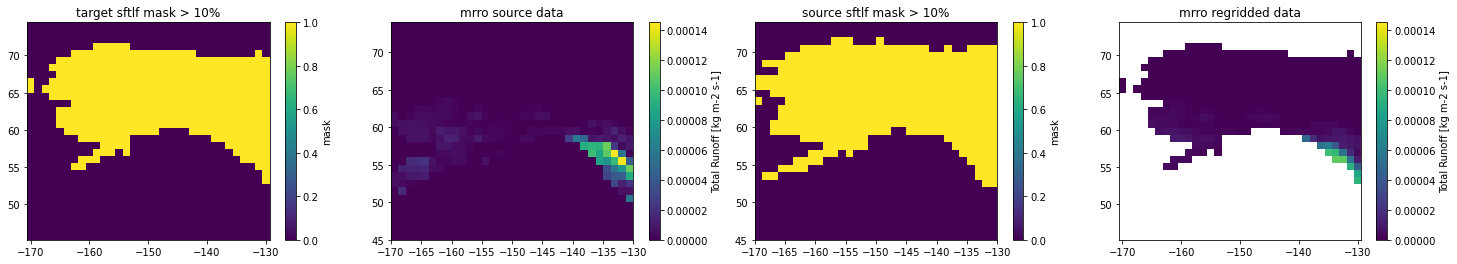

EC-Earth3-Veg: mrro and sftlf files found...regridding with model-specific land/sea mask
EC-Earth3-Veg:


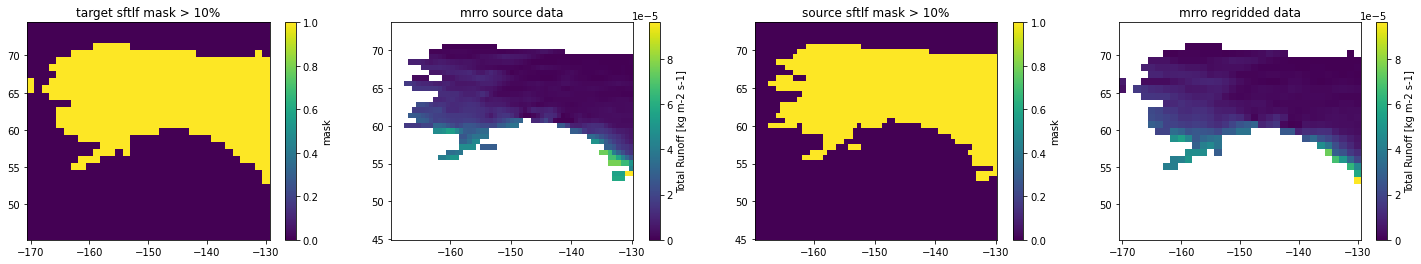

MIROC6: mrro and sftlf files found...regridding with model-specific land/sea mask
MIROC6:


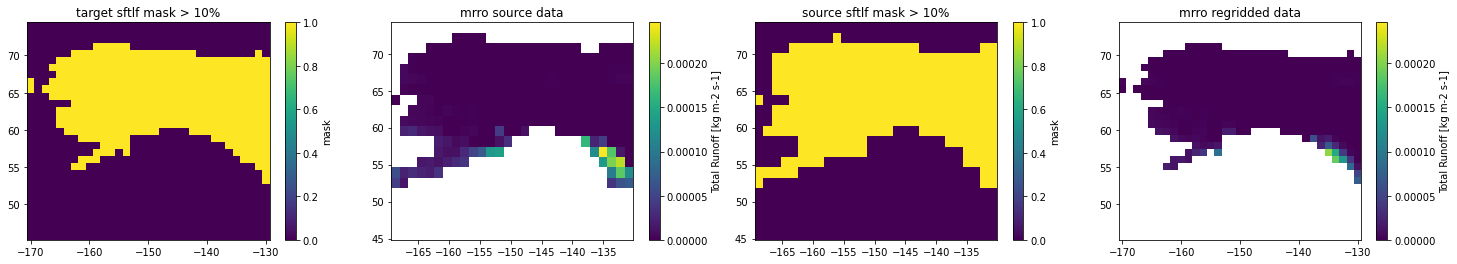

HadGEM3-GC31-MM: mrro files found, but no sftlf files found...regridding without model-specific land/sea mask
HadGEM3-GC31-MM:


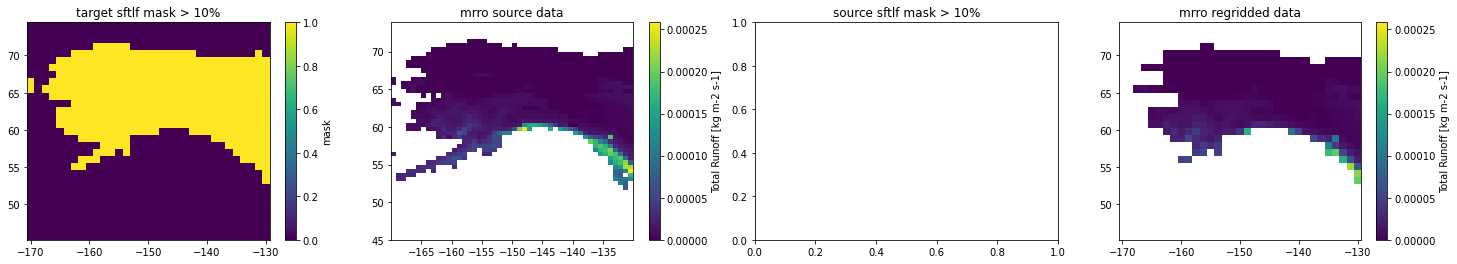

MPI-ESM1-2-HR: mrro and sftlf files found...regridding with model-specific land/sea mask
MPI-ESM1-2-HR:


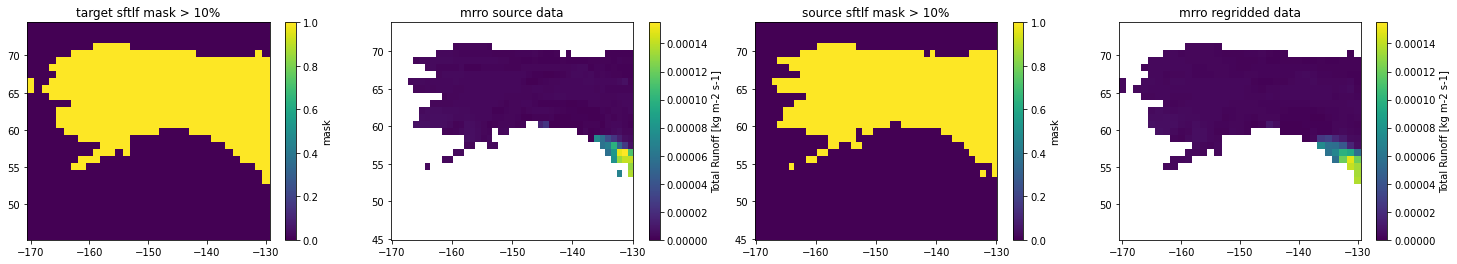

MRI-ESM2-0: mrro and sftlf files found...regridding with model-specific land/sea mask
MRI-ESM2-0:


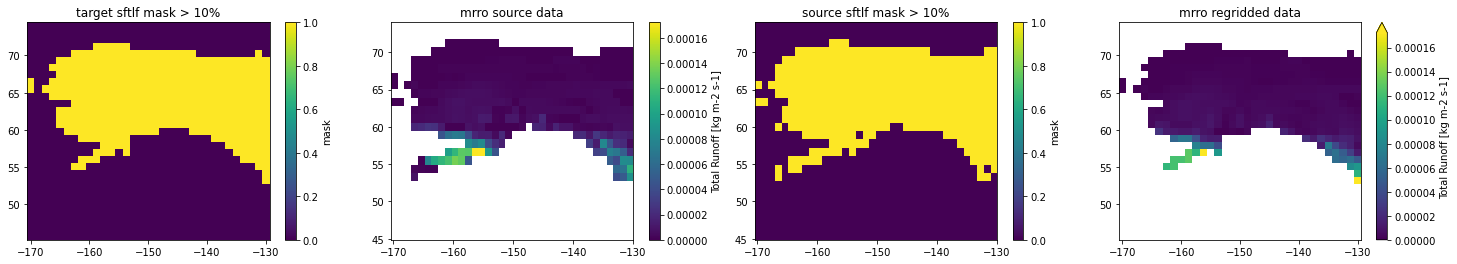

In [89]:
threshold = 10
var = "mrro"
mask_var = "sftlf"

# define CESM2 target grid dataset and land/sea mask
target_ds = load_ds(regrid_demo_dict["CESM2"][var])
target_land_mask = load_ds(regrid_demo_dict["CESM2"][mask_var], time=False)

# for each model, define source dataset and land/sea mask, then regrid and plot
for model in regrid_demo_dict.keys():
    # skip if var or land/sea mask files are not found
    if regrid_demo_dict[model][var] is None:
        print(f"{model}: no {var} files found to regrid\n")
        continue
    elif regrid_demo_dict[model][mask_var] is None:
        print(
            f"{model}: {var} files found, but no {mask_var} files found...regridding without model-specific land/sea mask"
        )
        src_ds = load_ds(regrid_demo_dict[model][var])
        print(f"{model}:")
        regrid_nolandseamask_and_plot(
            target_ds,
            target_land_mask,
            src_ds,
            threshold,
            var,
            mask_var,
            lat_slice,
            lon_slice,
        )

    else:
        print(
            f"{model}: {var} and {mask_var} files found...regridding with model-specific land/sea mask"
        )
        src_ds = load_ds(regrid_demo_dict[model][var])
        src_land_mask = load_ds(regrid_demo_dict[model][mask_var], time=False)
        print(f"{model}:")
        regrid_landseamask_and_plot(
            target_ds,
            target_land_mask,
            src_ds,
            src_land_mask,
            threshold,
            var,
            mask_var,
            lat_slice,
            lon_slice,
        )